# 1. Train models on `hand_pose_rps_dataset` 

## 1. a. Data Augmentation Helper Functions, Custom Layers

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import math

from hand_pose_rps_dataset import hand_pose_rps_dataset
import tensorflow_datasets as tfds

# generate random X,Y,Z rotation matrix
def random_axis_rotation_matrix():
    angle_x = tf.random.uniform([], -math.pi, math.pi)
    angle_y = tf.random.uniform([], -math.pi, math.pi)
    angle_z = tf.random.uniform([], -math.pi, math.pi)

    # Rotation matrices for each axis
    rot_x = tf.convert_to_tensor([
        [1.0, 0.0, 0.0],
        [0.0, tf.cos(angle_x), -tf.sin(angle_x)],
        [0.0, tf.sin(angle_x), tf.cos(angle_x)]
    ])

    rot_y = tf.convert_to_tensor([
        [tf.cos(angle_y), 0.0, tf.sin(angle_y)],
        [0.0, 1.0, 0.0],
        [-tf.sin(angle_y), 0.0, tf.cos(angle_y)]
    ])

    rot_z = tf.convert_to_tensor([
        [tf.cos(angle_z), -tf.sin(angle_z), 0.0],
        [tf.sin(angle_z), tf.cos(angle_z), 0.0],
        [0.0, 0.0, 1.0]
    ])

    # Pick matrix based on axis
    return rot_x @ rot_y @ rot_z

# given a point cloud, rotate it about X,Y,Z randomly
def random_rotate_pointcloud(points):
    rotation_matrix = random_axis_rotation_matrix()
    return tf.linalg.matmul(points, rotation_matrix)

# duplicate point cloud num_copies times with random X,Y,Z rotations
def duplicate_with_multiple_rotations(pose, label, num_copies=3):
    original = tf.data.Dataset.from_tensors((pose, label))

    def make_rotated(_):
        rotated = random_rotate_pointcloud(pose)
        return (rotated, label)

    # Create a dataset of N random rotations
    rotated_ds = tf.data.Dataset.range(num_copies).map(make_rotated)
    
    # Combine original + rotated copies
    return original.concatenate(rotated_ds)

# align hand pose inputs with "palm" plane. Helping counteract hand's rotation
class HandPoseAligner(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
    
    def call(self, joint_matrix):
        if len(joint_matrix.shape) == 3:
            joint_matrix = tf.expand_dims(joint_matrix, axis=0)
        if joint_matrix.shape[-1] == 1:
            joint_matrix = tf.squeeze(joint_matrix, axis=-1)

        
        origin_aligned_joint_matrix = joint_matrix - joint_matrix[:,0:1,:]

        p_wrist = origin_aligned_joint_matrix[:,0,:]
        p_index = origin_aligned_joint_matrix[:,5,:]
        p_pinky = origin_aligned_joint_matrix[:,17,:]
        
        v_index = p_index - p_wrist
        v_pinky = p_pinky - p_wrist

        
        x_axis = tf.linalg.l2_normalize(v_index, axis=-1)
        z_axis = tf.linalg.cross(v_index, v_pinky)
        z_axis = tf.linalg.l2_normalize(z_axis, axis=-1)
        y_axis = tf.linalg.cross(z_axis, x_axis)
        
        rotation_matrix = tf.stack([
            x_axis,
            y_axis,
            z_axis
            ], axis=-1)

        pose_aligned_joint_matrix = tf.matmul(origin_aligned_joint_matrix, rotation_matrix)
        pose_aligned_joint_matrix = tf.expand_dims(pose_aligned_joint_matrix, axis=-1)
            
        return pose_aligned_joint_matrix

class FingerDistanceIsolator(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
    
    def call(self, joint_matrix):
        if len(joint_matrix.shape) == 3:
            joint_matrix = tf.expand_dims(joint_matrix, axis=0)
        if joint_matrix.shape[-1] == 1:
            joint_matrix = tf.squeeze(joint_matrix, axis=-1)

        # grab the endpoints of each finger
        p_wrist = joint_matrix[:,0,:]
        p_thumb = joint_matrix[:,4,:]
        p_index = joint_matrix[:,8,:]
        p_middle = joint_matrix[:,12,:]
        p_ring = joint_matrix[:,16,:]
        p_pinky = joint_matrix[:,20,:]
        
        d_thumb = tf.linalg.norm(p_thumb - p_wrist, axis=-1)
        d_index = tf.linalg.norm(p_index - p_wrist, axis=-1)
        d_middle = tf.linalg.norm(p_pinky - p_wrist, axis=-1)
        d_ring = tf.linalg.norm(p_ring - p_wrist, axis=-1)
        d_pinky = tf.linalg.norm(p_pinky - p_wrist, axis=-1)

        d_fingers = tf.stack([d_thumb, d_index, d_middle, d_ring, d_pinky], axis=-1)
        d_fingers = tf.expand_dims(d_fingers, axis=-1)
        return d_fingers


## 1. b. Grab dataset, Augment with Random XYZ Rotations

In [39]:
# grab custom rock, paper, scissors point cloud dataset (see sec. 4)
builder = hand_pose_rps_dataset.MyHandPoseRpsDataset()  # Your dataset class
# builder.download_and_prepare() # call if not already downloaded and prepared
train = builder.as_dataset(split='train', as_supervised=True)
test = builder.as_dataset(split='test', as_supervised=True)

# augment dataset with random rotations
num_augments = 10  # Number of augmentations per sample
train = train.flat_map(lambda pose, label: 
    duplicate_with_multiple_rotations(pose, label, num_augments)
)
test = test.flat_map(lambda pose, label: 
    duplicate_with_multiple_rotations(pose, label, num_augments)
)

# check how many samples generated after augmentation
sample_cnt = 0
for _ in train:
    sample_cnt += 1
print(f"No. of training samples after augmentation: {sample_cnt}")

# expand dimensions to match Conv2D input shape
train = train.map(lambda x, y: (tf.expand_dims(x, -1), y))
test = test.map(lambda x, y: (tf.expand_dims(x, -1), y))

# batch dataset
batch_size = 64
train = train.batch(batch_size)
test = test.batch(batch_size)

No. of training samples after augmentation: 26532


## 1. c. Build Conv2D Model (No Hand Pose Alignment)

In [24]:
# build model via Functional API
inputs = tf.keras.Input(shape=(21,3,1))
x = tf.keras.layers.LayerNormalization(axis=1)(inputs)
x = tf.keras.layers.Conv2D(4, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(4, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.AveragePooling2D(pool_size=(4, 1))(x)
#x = tf.keras.layers.Conv2D(8, 3, activation='relu', padding='same')(x)
#x = tf.keras.layers.Conv2D(8, 3, activation='relu', padding='same')(x)
#x = tf.keras.layers.AveragePooling2D(pool_size=(2, 1))(x)
#x = tf.keras.layers.Dropout(0.5)(x)
# classification head
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
#x = tf.keras.layers.Dense(8, activation='relu')(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

# compile model
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 21, 3, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_8           │ (None, 21, 3, 1)       │            42 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 21, 3, 4)       │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 21, 3, 4)       │           148 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_8             │ (None, 5, 3, 4)        │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 16)             │           976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,257 (4.91 KB)

 Trainable params: 1,257 (4.91 KB)

 Non-trainable params: 0 (0.00 B)

## 1. d. Build Conv2D model (With HandPoseAligner)

In [49]:
# build model using HandPoseAligner layer
inputs = tf.keras.Input(shape=(21,3,1))
x = tf.keras.layers.LayerNormalization(axis=1)(inputs)
x = HandPoseAligner()(x)
x = tf.keras.layers.Conv2D(4, 3, activation='relu', padding='same')(x)
# x = tf.keras.layers.Conv2D(4, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.AveragePooling2D(pool_size=(4, 1))(x)
x = tf.keras.layers.Dropout(0.2)(x)
# classification head
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(8, activation='relu')(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

# compile model
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 21, 3, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_16          │ (None, 21, 3, 1)       │            42 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hand_pose_aligner_6             │ (None, 21, 3, 1)       │             0 │
│ (HandPoseAligner)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 21, 3, 4)       │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_15            │ (None, 5, 3, 4)        │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 5, 3, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 8)              │           488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 597 (2.33 KB)

 Trainable params: 597 (2.33 KB)

 Non-trainable params: 0 (0.00 B)

## 1. e. Build MLP Model (With FingerDistanceIsolator)

In [44]:
inputs = tf.keras.Input(shape=(21,3,1))
x = FingerDistanceIsolator()(inputs)
x = tf.keras.layers.LayerNormalization(axis=1)(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 21, 3, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ finger_distance_isolator        │ (None, 5, 1)           │             0 │
│ (FingerDistanceIsolator)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_15          │ (None, 5, 1)           │            10 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 3)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28 (112.00 B)

 Trainable params: 28 (112.00 B)

 Non-trainable params: 0 (0.00 B)

## 1. f. Train `model`, Visualize Results

Epoch 1/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4564 - loss: 1.0074 - val_accuracy: 0.9980 - val_loss: 0.2004
Epoch 2/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8759 - loss: 0.3731 - val_accuracy: 0.9995 - val_loss: 0.0621
Epoch 3/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9194 - loss: 0.2375 - val_accuracy: 0.9998 - val_loss: 0.0345
Epoch 4/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9367 - loss: 0.1813 - val_accuracy: 0.9990 - val_loss: 0.0283
Epoch 5/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9521 - loss: 0.1368 - val_accuracy: 0.9998 - val_loss: 0.0176
Epoch 6/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9641 - loss: 0.1058 - val_accuracy: 0.9998 - val_loss: 0.0167
Epoch 7/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9706 - loss: 0.0841 - val_accuracy: 1.0000 - val_loss: 0.0129
Epoch 8/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9732 - loss: 0.0763 - val_accuracy: 1.

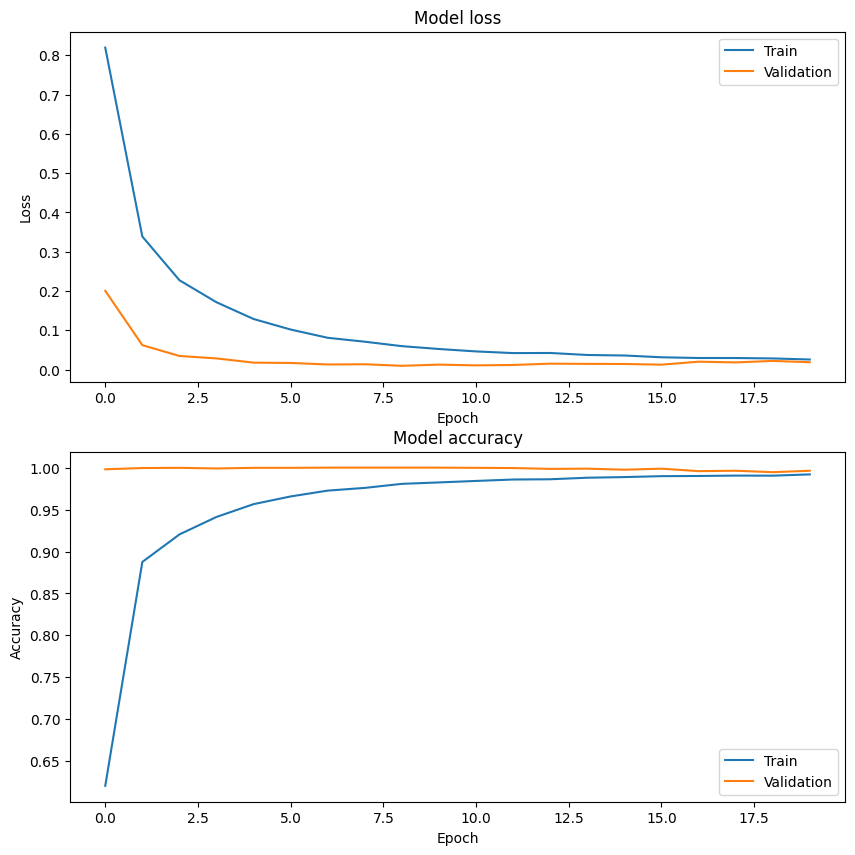

In [50]:
history = model.fit(train, batch_size=batch_size,epochs=20,validation_data=test,shuffle=True)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
# Plot training & validation loss values
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_title('Model loss')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
axes[1].plot(history.history['accuracy'])
axes[1].plot(history.history['val_accuracy'])
axes[1].set_title('Model accuracy')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
# save model
# model.save("model/hand_pose_rps_conv2d_alignment_model.keras")

## 1. g. Measure `model`'s timing performance on `image.png`

In [51]:
import mediapipe as mp
import cv2
import numpy as np
import tensorflow as tf

# load mediapipe
mp_hands = mp.solutions.hands

# load hand pose rps classification model
# model = tf.keras.models.load_model("model/hand_pose_rps_conv2d_model.keras")

# load simple test image
image = cv2.imread("image.png")
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

# process image with mediapipe, measure execution time of model
with mp_hands.Hands(
    model_complexity=0,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:

    results = hands.process(image)
    
    if results.multi_hand_landmarks:
      for hand_landmarks in results.multi_hand_landmarks:
        joint_matrix = np.expand_dims(np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark]),axis=-1)

        %timeit model(np.expand_dims(joint_matrix, axis=0), training=False)
        

6.21 ms ± 61.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# 2. Connect to webcam for testing MediaPipe hand pose estimation and classification

Helper functions

Main code

In [47]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time


# load model if already trained
# model = tf.keras.models.load_model("model/hand_pose_rps_conv2d_model.keras")

# load mediapipe hand model
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

# grab webcam (most of this copied from MediaPipe example code)
cap = cv2.VideoCapture(0)
with mp_hands.Hands(
    model_complexity=0,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:


  while cap.isOpened():
    t0 = time.time()
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      continue

    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image)

    # Draw the hand annotations on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    h, w, _ = image.shape

    if results.multi_hand_landmarks:
      for hand_landmarks in results.multi_hand_landmarks:
        
        mp_drawing.draw_landmarks(
            image,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())
        
        
        # get hand coordinates and classify
        joint_matrix = np.expand_dims(np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark]),axis=-1)

        # grab min, max values for bounding box
        x_min, y_min = np.min(joint_matrix, axis=0)[:2]
        x_max, y_max = np.max(joint_matrix, axis=0)[:2]
        
        x_min = int(x_min * w)
        x_max = int(x_max * w)
        y_min = int(y_min * h)
        y_max = int(y_max * h)

        # classify hand pose
        gestures = model(np.expand_dims(joint_matrix, axis=0), training=False)

        # get class and label on image
        label_names = ['rock', 'paper', 'scissors']
        gesture_class = label_names[np.argmax(gestures, axis=1)[0]]
        # Draw bounding box and label
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv2.putText(image, gesture_class, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0, 255, 0), 2, cv2.LINE_AA)
        

    # track FPS on image
    fps=1/(time.time() - t0)

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_thickness = 2
    text_color = (0, 255, 0)

    # calculate FPS
    text = f"FPS: {fps:.2f}"

    # Get text size
    (text_width, text_height), _ = cv2.getTextSize(text, font, font_scale, font_thickness)

    # Position: top-right corner with some padding
    x = w - text_width - 10  # 10px from right
    y = text_height + 10               # 10px from top

    # draw fps
    cv2.putText(image, text, (x, y), font, font_scale, text_color, font_thickness)

    # close window by pressing 'ESC' key
    cv2.imshow('MediaPipe Hands', image)
    if cv2.waitKey(5) & 0xFF == 27:
      break

# release webcam and close window
import time
cap.release()
cv2.destroyAllWindows()
time.sleep(0.1)


C:\Users\colli\AppData\Local\Temp\ipykernel_51916\98594406.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_min = int(x_min * w)
C:\Users\colli\AppData\Local\Temp\ipykernel_51916\98594406.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_max = int(x_max * w)
C:\Users\colli\AppData\Local\Temp\ipykernel_51916\98594406.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_min = int(y_min * h)
C:\Users\colli\AppData\Local\Temp\ipykernel_51916\98594406.py:65

# 3. Visualizing MediaPipe Hand Pose Estimation on Static Image

In [ ]:
import tensorflow_datasets as tfds
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

# Load the rock_paper_scissors dataset
dataset, info = tfds.load('rock_paper_scissors', split='train', with_info=True)
data_iter = iter(tfds.as_numpy(dataset))


Index finger tip coordinates: ( 110.29012799263, 54.32505011558533)


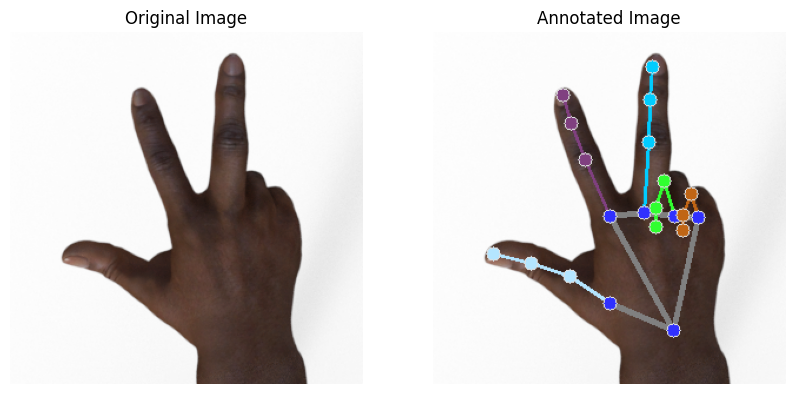

In [ ]:
# Get one sample image and its label
sample = next(data_iter)
image = sample['image']#cv2.imread("image.png")

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

# For static images:
with mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5) as hands:
    # Convert the BGR image to RGB before processing.
    results = hands.process(image)#cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    image_height, image_width, _ = image.shape
    annotated_image = image.copy()
    
    for hand_landmarks in results.multi_hand_landmarks:
      #print('hand_landmarks:', hand_landmarks)
      print(
          f'Index finger tip coordinates: (',
          f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x * image_width}, '
          f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y * image_height})'
      )
      mp_drawing.draw_landmarks(
          annotated_image,
          hand_landmarks,
          mp_hands.HAND_CONNECTIONS,
          mp_drawing_styles.get_default_hand_landmarks_style(),
          mp_drawing_styles.get_default_hand_connections_style())
          


# Display the original and annotated images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Annotated Image")
plt.imshow(annotated_image)
plt.axis('off')

plt.show()

# 4. Code used to make `hand_pose_rps_dataset`

In [ ]:
'''
import cv2
import os

splits = ['train', 'test']

for split in splits:

    # Load the rock_paper_scissors dataset
    dataset, info = tfds.load('rock_paper_scissors', split=split, with_info=True)
    mp_hands = mp.solutions.hands


    with mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5) as hands:
        # init sample structure
        hand_pose_rps_sample = {
            'pose' : [],
            'label' : []
        }

        for index, sample in enumerate(tfds.as_numpy(dataset)):
            # grab image and label
            image = sample['image']
            label = sample['label']

            # process image
            results = hands.process(image)
            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    # Convert the landmarks to a NumPy array
                    joint_matrix = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark])
                    hand_pose_rps_sample['pose'] = joint_matrix
                    hand_pose_rps_sample['label'] = int(label)

                    filepath = os.path.join(f'hand_pose_rps_dataset/{split}', f'hand_pose_rps_{split}_{index}')
                    np.save(filepath, hand_pose_rps_sample)
                    cv2.imwrite(filepath + ".jpg", image)
'''
